In [1]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.util import random_noise
from __future__ import print_function
from __future__ import division
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import time
import os
import copy
from skimage.filters import gaussian

data_folder = os.path.abspath('./data')
image_folder = os.path.join(data_folder, 'TRANCOS')

print(image_folder)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available() == False:
    print('\033[91m' + "You are training on CPU, are you sure you want to continue?" + '\033[0m')

torch.manual_seed(1)

/mnt/c/Users/Alix/Desktop/school/Semester_5/projects/project-415/data/TRANCOS


In [2]:
# Hyperparameters
img_size = (224, 224, 3)
batch_size = 32

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 1

# Number of epochs to train for
num_epochs = 60
num_epochs_finetune = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


In [3]:
# data augmentation
csv = pd.read_csv(os.path.join(data_folder, 'train.csv'))
csv = pd.Series(csv.counts.values,index=csv.images).to_dict()
images = list(csv.keys())
labels = list(csv.values())

if len(images) != len(labels):
    raise ValueError("Image and label arrays do not have the same size in train dataset.")

for img, label in zip(images, labels):
    image0 = os.path.join(image_folder, img.rstrip('.jpg') + '-0.jpg')
    image1 = os.path.join(image_folder, img.rstrip('.jpg') + '-1.jpg')
    image2 = os.path.join(image_folder, img.rstrip('.jpg') + '-2.jpg')
    image3 = os.path.join(image_folder, img.rstrip('.jpg') + '-3.jpg')
    image4 = os.path.join(image_folder, img.rstrip('.jpg') + '-4.jpg')

    # if they already exist, no need to redo the data augmentation
    if os.path.exists(image0) and os.path.exists(image1) and os.path.exists(image2) and os.path.exists(image3) and os.path.exists(image4):
        continue

    image = cv2.normalize(cv2.resize(plt.imread(os.path.join(image_folder, img)), img_size[:2]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    plt.imsave(image0, image)
    plt.imsave(image1, np.fliplr(image))
    plt.imsave(image2, np.flipud(image))
    plt.imsave(image3, random_noise(image,var=0.2**2))
    plt.imsave(image4, gaussian(image,sigma=1,multichannel=True))
    

In [4]:
# dataset class

class CustomDataset(Dataset):
    def __init__(self, type):

        self.type = type
        csv = pd.read_csv(os.path.join(data_folder, self.type + '.csv'))

        if self.type == 'train' or self.type == 'valid':
            csv = pd.Series(csv.counts.values,index=csv.images).to_dict()

            # getting the images 
            self.images = []
            self.labels = []
            images = list(csv.keys())
            labels = list(csv.values())
            if len(images) != len(labels):
                raise ValueError("Image and label arrays do not have the same size.")
            
            if self.type == 'valid':
                self.images = [os.path.join(image_folder, img) for img in images]
                self.labels = labels
            else:
                for img, label in zip(images, labels):
                    # adding augmented data to list
                    for i in range(5):
                        self.images.append(os.path.join(image_folder, img.rstrip('.jpg') + '-' + str(i) + '.jpg'))
                        self.labels.append(label)

            if len(self.images) != len(self.labels):
                raise ValueError("Image and label arrays do not have the same size or some values in these arrays are None.")

        elif self.type == 'test':

            # getting the images
            self.images = list(csv.images.values.tolist())

        else:
            raise ValueError("Invalid type in dataset. It has to have one of the following values: 'train', 'valid', 'test'.")
        print("Initiated " + self.type + " dataset of size " + str(len(self.images)) + " and images of shape " + str(list(img_size)))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        if self.type == 'test':
            return cv2.normalize(cv2.resize(plt.imread(os.path.join(image_folder, self.images[i])), img_size[:2]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), self.images[i]
        else:
             return cv2.normalize(cv2.resize(plt.imread(os.path.join(image_folder, self.images[i])), img_size[:2]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), self.labels[i]

In [5]:
# declaring datasets and data loaders

train_dataset = CustomDataset('train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = CustomDataset('valid')
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset('test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Initiated train dataset of size 3115 and images of shape [224, 224, 3]
Initiated valid dataset of size 200 and images of shape [224, 224, 3]
Initiated test dataset of size 421 and images of shape [224, 224, 3]


In [6]:
# model
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 224

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, num_classes))

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, num_classes))

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, num_classes))

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, num_classes))

    else:
        print("Invalid model name, exiting...")
        exit()
    
    model_ft = model_ft.to(device)

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

PyTorch Version:  1.10.0+cu102
Torchvision Version:  0.11.1+cu102
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [7]:
# training
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    train_loss = []
    validation_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000000000000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    inputs = inputs.permute(0,3,1,2) # remap the inputs at the good spot
                    outputs = model(inputs)
                    loss = criterion(outputs[:,0], labels.float()) # cast the output as a 1D tensor and the inputs as float

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
                
            if phase == 'val':
                validation_loss.append(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                
            elif phase == 'train':
                train_loss.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    print("Best validation loss: " + str(min(validation_loss)))
    return model, train_loss, validation_loss


print("Params to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

# Setup the loss fxn
# criterion = nn.CrossEntropyLoss()
loss = nn.MSELoss()

dataloaders = {'train': train_loader, 'val':valid_loader}

# Train and evaluate
model_ft, train_hist, valid_hist = train_model(model_ft, dataloaders, loss, optimizer_ft, num_epochs=num_epochs)

Params to learn:
	 classifier.6.0.weight
	 classifier.6.0.bias
	 classifier.6.3.weight
	 classifier.6.3.bias
Epoch 0/59
----------
train Loss: 336.7022
val Loss: 166.6777
Epoch 1/59
----------
train Loss: 161.9725
val Loss: 89.9879
Epoch 2/59
----------
train Loss: 158.0947
val Loss: 129.5759
Epoch 3/59
----------
train Loss: 143.6978
val Loss: 117.0929
Epoch 4/59
----------
train Loss: 145.6419
val Loss: 87.4870
Epoch 5/59
----------
train Loss: 147.6164
val Loss: 88.6038
Epoch 6/59
----------
train Loss: 142.5315
val Loss: 93.2764
Epoch 7/59
----------
train Loss: 136.6764
val Loss: 114.7374
Epoch 8/59
----------
train Loss: 137.5882
val Loss: 82.6805
Epoch 9/59
----------
train Loss: 137.1133
val Loss: 92.2165
Epoch 10/59
----------
train Loss: 130.5436
val Loss: 80.0015
Epoch 11/59
----------
train Loss: 137.5462
val Loss: 83.9637
Epoch 12/59
----------
train Loss: 134.6878
val Loss: 86.2888
Epoch 13/59
----------
train Loss: 120.5542
val Loss: 99.2285
Epoch 14/59
----------
train 

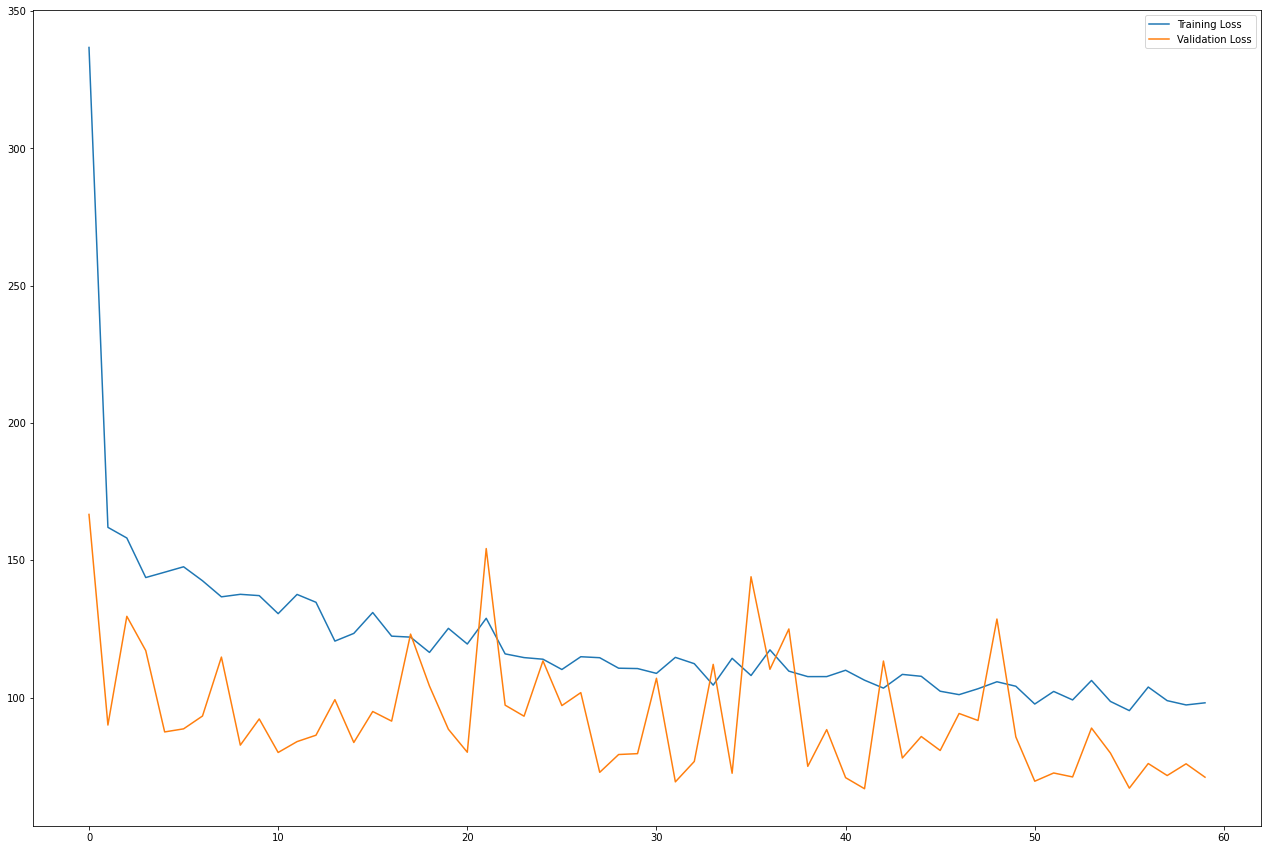

In [8]:
# training results
plt.gcf().set_size_inches(22, 15, forward=True)

plt.plot(train_hist, label='training loss')
plt.plot(valid_hist, label='validation loss')

plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [9]:
params_to_update = model_ft.parameters()

print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.00001, momentum=0.9)

model_ft, train_hist, valid_hist = train_model(model_ft, dataloaders, loss, optimizer_ft, num_epochs=num_epochs_finetune)

Params to learn:
	 classifier.6.0.weight
	 classifier.6.0.bias
	 classifier.6.3.weight
	 classifier.6.3.bias
Epoch 0/9
----------
train Loss: 101.7104
val Loss: 88.5421
Epoch 1/9
----------
train Loss: 98.3347
val Loss: 80.8489
Epoch 2/9
----------
train Loss: 97.2195
val Loss: 85.3651
Epoch 3/9
----------
train Loss: 97.2963
val Loss: 77.4683
Epoch 4/9
----------
train Loss: 95.3704
val Loss: 84.2715
Epoch 5/9
----------
train Loss: 98.2655
val Loss: 79.8388
Epoch 6/9
----------
train Loss: 101.8516
val Loss: 86.9653
Epoch 7/9
----------
train Loss: 98.4679
val Loss: 80.8997
Epoch 8/9
----------
train Loss: 94.4324
val Loss: 81.1311
Epoch 9/9
----------
train Loss: 94.0251
val Loss: 84.7635
Training complete in 8m 23s
Best validation loss: 77.46834228515625


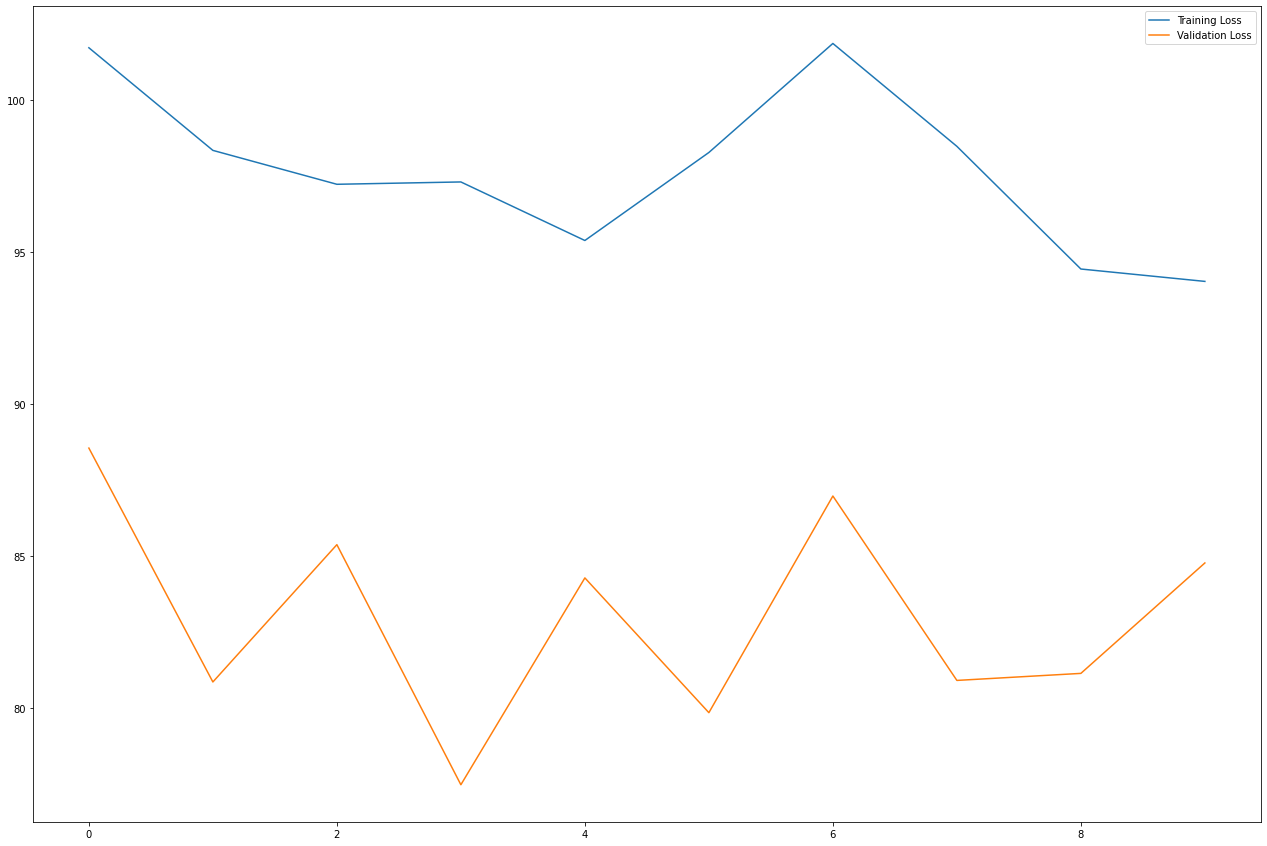

In [10]:
# training results
plt.gcf().set_size_inches(22, 15, forward=True)

plt.plot(train_hist, label='training loss')
plt.plot(valid_hist, label='validation loss')

plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [11]:
# saving model
PATH = './models/model.hdf5'
torch.save(model_ft, PATH)

In [12]:
# calculating accuracy of model
import csv

model_ft.eval()

im_name = []
count = []
for inputs, name in test_loader:
    inputs = inputs.permute(0,3,1,2) # remap the inputs at the good spot
    inputs = inputs.to(device)
    outputs = model_ft(inputs)
    out_int = [int(item) for item in outputs[:,0].tolist()]
    count.extend(out_int)
    im_name.extend(name)

out = [['images'], ['counts']]
out[0].extend(im_name)
out[1].extend(count)

out2 = zip(*out)
out3 = list(out2)

with open('test_out.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    for x in out3:
        write.writerow(x)
    f.close()

# Accuracy Evaluation
### Note: the following are computed on validation data and I know we are not supposed to but we had no other evaluation data.

In [46]:
predictions = []
labels = []

# getting the predictions
for input, label in valid_loader:
    input = input.permute(0,3,1,2) # remap the inputs at the good spot
    input = input.to(device)
    output = model_ft(input).cpu().detach().numpy()
    output = output.squeeze().tolist()
    predictions += output
    labels += label.cpu().detach().numpy().tolist()

In [47]:
# Compute MDE Metric
def MDE (predictions, expected_counts):
  mean_ac = []
  for prediction, expectation in zip(predictions, expected_counts):
    accuracy = (prediction/expectation)*100
    ac = np.append(mean_ac, accuracy)
  # Compute mean of results
  return np.mean(ac)
print('Mean Deviation Error: ' + str(MDE(predictions, labels))+ ' %')

Mean Deviation Error: 128.1810336642795 %


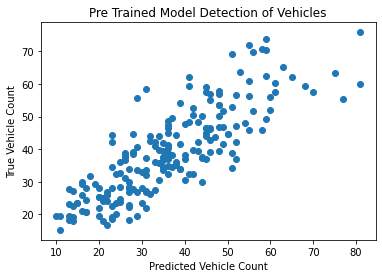

In [48]:
# Scatter point
import matplotlib.pyplot as plt
true_vehicle_counts = len(labels)
fig, ax = plt.subplots()
ax.scatter(labels, predictions)
ax.set_xlabel('Predicted Vehicle Count')
ax.set_ylabel('True Vehicle Count')
ax.set_title('Pre Trained Model Detection of Vehicles')
plt.show()

In [49]:
# Pearson correlation coefficient
from scipy import stats
r, p = stats.pearsonr(labels, predictions)
print('Pearson’s Correlation Coefficient: ' + str(r))

Pearson’s Correlation Coefficient: 0.8267187550847946


In [50]:
from sklearn.metrics import mean_absolute_error
# Mean absolute error
mae = mean_absolute_error(labels, predictions)
print('Mean Absolute Error: ' + str(mae))

Mean Absolute Error: 7.0782183647155765


In [51]:
from sklearn.metrics import mean_squared_error
# Mean square error
mse = mean_squared_error(labels, predictions)
print('Mean Square Error: ' + str(mse))

Mean Square Error: 77.46834276447552
